In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, exists
import random
from random import random as rand

from tqdm import tqdm

In [2]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [3]:
np.set_printoptions(precision=5, suppress=True)

In [4]:
sig1 = 0.682689492137
sig2 = 0.954499736104
sig3 = 0.997300203937

In [5]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [6]:
def calc_hit(file_behav, tpr=97, nrun=6):
    ##### parameters #####
    ## file_behav: 불러올 .mat 파일 경로
    ## tpr: trial per run, default=97 (GA project)
    ## nrun: 불러올 run 수, 예) nrun=4 일 경우, r01~r04 까지 데이터를 불러옴
    
    datum = scipy.io.loadmat(file_behav)
    
    ## frame per trial
    fpt = int(datum['nSampleTrial'][0][0])
    ## second per trial
    spt = int(fpt/60.)
    ## a number of trials per run
    # tpr = datum['nTrialperRun'][0][0]
#     tpr = 97  # 12 trial/block * 8 block/run + 1 = 97 trial/run

    ## target ID
    tmp = datum['targetID'][0]
    targetID = tmp[tmp!=0][:tpr*nrun]

    bx = datum['boxSize'][0][0]
    pos = bx*convert_ID(targetID)
    
    ## 60 Hz * {5 s/trial * (1 trial + 12 trial/block * 8 block)}/Run * 3 Run = 87300
    allXY = datum['allXY']
    
    xFrame, yFrame = np.array([datum['xFrame'].squeeze(), datum['yFrame'].squeeze()]).astype(int)
    
    ## target position
    tmp = np.zeros(allXY.shape)
    for i in range(fpt*tpr*nrun):
        t = np.floor(i/fpt).astype(int)
        tmp[0][i], tmp[1][i] = pos[0][t], pos[1][t]

    ## Is it hit?
    err = allXY - tmp
    hit = np.zeros(fpt*tpr*nrun)
    for i in range(fpt*tpr*nrun):
        hit[i] = abs(err[0][i]) <= bx*.5 and abs(err[1][i]) <= bx*.5
        
    return hit

GA

In [7]:
dir_work = '/home/sungbeenpark/Github/labs/GA'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-fmri.mat')))

df_GA = pd.DataFrame(columns=['subj']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GA.loc[i]['subj'] = subj
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GA.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GA

100%|██████████| 30/30 [00:33<00:00,  1.10s/it]


,subj,0,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,47
0,GA01,0.225833,0.221389,0.370833,0.316389,0.341389,0.389444,0.266667,0.379444,0.476389,...,0.429167,0.43,0.3975,0.405,0.263889,0.265833,0.33,0.223333,0.338611,0.304722
1,GA02,0.382778,0.487222,0.434722,0.219167,0.381111,0.498611,0.438333,0.391944,0.366389,...,0.43,0.453611,0.36,0.458611,0.542222,0.489167,0.498611,0.498056,0.573889,0.533611
2,GA05,0.040556,0.402222,0.246389,0.094167,0.221667,0.204167,0.045,0.206944,0.305833,...,0.216111,0.394722,0.395556,0.446389,0.453333,0.299167,0.435556,0.452778,0.375833,0.531389
3,GA07,0.146389,0.240833,0.07,0.1925,0.293056,0.286111,0.257222,0.196944,0.233889,...,0.617778,0.565833,0.543333,0.374167,0.544167,0.540278,0.556667,0.598333,0.480278,0.5275
4,GA08,0.263889,0.233056,0.411667,0.432222,0.258056,0.673889,0.530833,0.488611,0.341389,...,0.348056,0.330556,0.437778,0.4675,0.421111,0.240556,0.444167,0.460556,0.348889,0.489722
5,GA11,0.043611,0.206389,0.144722,0.168611,0.27,0.231111,0.255,0.241111,0.167222,...,0.341389,0.4,0.335833,0.410278,0.235278,0.244444,0.264722,0.343056,0.343889,0.290556
6,GA12,0.132222,0.1525,0.167222,0.368333,0.107778,0.115,0.289167,0.252778,0.234722,...,0.439167,0.394167,0.365278,0.260556,0.492222,0.393889,0.335,0.450278,0.342222,0.440556
7,GA13,0.135833,0.254444,0.338333,0.197778,0.2525,0.346389,0.458056,0.305,0.302778,...,0.441111,0.640278,0.479722,0.466667,0.494444,0.605,0.432222,0.582222,0.532778,0.518333
8,GA14,0.121944,0.128056,0.136944,0.138889,0.281667,0.16,0.0825,0.138056,0.148611,...,0.186389,0.196389,0.076111,0.123611,0.2225,0.235833,0.236667,0.270833,0.311667,0.255
9,GA15,0.108333,0.205278,0.293056,0.185556,0.237222,0.171389,0.233611,0.2225,0.328889,...,0.648056,0.694167,0.556111,0.631389,0.660278,0.683333,0.665556,0.687778,0.682222,0.645


In [8]:
dir_work = '/home/sungbeenpark/Github/labs/GA'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

df_GB = pd.DataFrame(columns=['subj']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GB.loc[i]['subj'] = subj.replace('GA','GB')
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GB.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GB

100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


,subj,0,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,47
0,GB01,0.6625,0.800833,0.651667,0.809167,0.783333,0.798056,0.790556,0.819722,0.809167,...,0.656944,0.726944,0.722222,0.710833,0.753611,0.740556,0.793056,0.739444,0.752778,0.798056
1,GB02,0.731944,0.796389,0.824444,0.787778,0.803056,0.785556,0.823889,0.828333,0.7975,...,0.650278,0.663611,0.644722,0.693611,0.695556,0.707778,0.639167,0.614167,0.600278,0.75
2,GB05,0.508333,0.633611,0.722778,0.629722,0.694444,0.652778,0.591111,0.624167,0.659167,...,0.604444,0.731667,0.437222,0.591944,0.596389,0.559444,0.537222,0.596944,0.666111,0.648889
3,GB07,0.526944,0.752222,0.755,0.723611,0.709167,0.725278,0.703889,0.732222,0.767778,...,0.5625,0.564722,0.622222,0.666944,0.660556,0.635556,0.700278,0.702222,0.538611,0.631111
4,GB08,0.419444,0.646389,0.641389,0.565,0.718056,0.665556,0.731944,0.596667,0.665833,...,0.396111,0.429444,0.428611,0.417222,0.431111,0.430278,0.483611,0.430556,0.624444,0.513056
5,GB11,0.5975,0.6525,0.618889,0.605,0.555,0.576111,0.525278,0.679722,0.557222,...,0.298611,0.322778,0.449444,0.390278,0.373889,0.210833,0.388889,0.412222,0.4175,0.296667
6,GB12,0.562778,0.694722,0.5725,0.618056,0.6025,0.623333,0.606667,0.590833,0.644444,...,0.286667,0.257222,0.319167,0.342778,0.215556,0.2025,0.354444,0.329444,0.333056,0.408333
7,GB13,0.735833,0.726944,0.741111,0.696111,0.744722,0.774444,0.665278,0.6675,0.731667,...,0.505278,0.383889,0.556111,0.612222,0.629722,0.5625,0.542778,0.597778,0.574167,0.526667
8,GB14,0.471667,0.602778,0.605278,0.636111,0.694167,0.696389,0.639167,0.759722,0.748611,...,0.42,0.542222,0.3975,0.468611,0.411111,0.520556,0.503056,0.519722,0.645556,0.61
9,GB15,0.715,0.6825,0.771111,0.741667,0.731944,0.753889,0.751111,0.748056,0.734444,...,0.436389,0.336667,0.431944,0.524444,0.51,0.598611,0.557778,0.593056,0.458333,0.569444


GD

In [9]:
dir_work = '/home/sungbeenpark/Github/labs/GD'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

df_GD = pd.DataFrame(columns=['subj']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GD.loc[i]['subj'] = subj
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GD.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GD

100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


,subj,0,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,47
0,GD01,0.185,0.477778,0.471667,0.419444,0.412778,0.5275,0.569444,0.623611,0.683611,...,0.569444,0.605556,0.493889,0.589167,0.596111,0.471667,0.546667,0.637222,0.641944,0.585833
1,GD02,0.570278,0.705278,0.713333,0.755833,0.799444,0.7775,0.774444,0.793889,0.740278,...,0.376389,0.585278,0.632778,0.540278,0.607778,0.662778,0.668056,0.628889,0.6675,0.696389
2,GD07,0.379444,0.381111,0.382222,0.514444,0.601111,0.601944,0.610833,0.561667,0.603333,...,0.090833,0.358333,0.36,0.357222,0.482222,0.511389,0.391111,0.508333,0.248611,0.425
3,GD11,0.176111,0.408333,0.544444,0.442778,0.447222,0.495,0.513889,0.636389,0.583611,...,0.425833,0.230833,0.391111,0.316944,0.263889,0.313056,0.263333,0.352222,0.339722,0.296944
4,GD15,0.206389,0.388333,0.4,0.476944,0.344444,0.5675,0.570556,0.591389,0.627778,...,0.278333,0.300278,0.500556,0.670278,0.694722,0.511111,0.706667,0.689167,0.752222,0.735278
5,GD20,0.224444,0.385833,0.373333,0.418889,0.455278,0.5325,0.413056,0.423611,0.415,...,0.418333,0.396667,0.3375,0.389167,0.39,0.343611,0.394722,0.381389,0.391667,0.435
6,GD23,0.699722,0.670833,0.681389,0.723056,0.713889,0.660833,0.548056,0.650833,0.526944,...,0.6225,0.544444,0.550833,0.556667,0.671389,0.345278,0.558056,0.57,0.607222,0.680833
7,GD26,0.553056,0.436111,0.480833,0.507778,0.551389,0.565556,0.570556,0.4825,0.653333,...,0.696667,0.689444,0.660833,0.752222,0.639167,0.745278,0.763611,0.760556,0.729167,0.73
8,GD29,0.281389,0.145,0.133333,0.178056,0.166389,0.091944,0.132222,0.136111,0.179722,...,0.441111,0.478056,0.415278,0.438889,0.443611,0.5175,0.590278,0.408333,0.609444,0.616389
9,GD30,0.553611,0.691111,0.741389,0.728889,0.760833,0.730833,0.733333,0.816389,0.748611,...,0.564167,0.552778,0.615278,0.506667,0.601111,0.654444,0.604722,0.525833,0.590556,0.602778


GP_DLPFC

In [10]:
dir_work = '/home/sungbeenpark/Github/labs/GP'
dir_data = join(dir_work, 'behav_data')
list_behav = []
for s in ['09', '10', '18' ,'21', '24']:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_dlpfc = pd.DataFrame(columns=['subj']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_dlpfc.loc[i]['subj'] = subj
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_dlpfc.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_dlpfc

100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


,subj,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,GP09,0.095278,0.006389,0.145833,0.107222,0.157222,0.038056,0.132222,0.089444,0.238333,...,0.180833,0.188889,0.3575,0.069444,0.072222,0.146667,0.169722,0.235,0.208611,0.214722
1,GP10,0.082222,0.167222,0.152222,0.1375,0.251389,0.201944,0.1525,0.150278,0.153056,...,0.194722,0.281944,0.198611,0.273333,0.129167,0.238333,0.224722,0.211944,0.377778,0.420833
2,GP18,0.013611,0.109722,0.098056,0.218056,0.339722,0.181389,0.228333,0.180278,0.246944,...,0.174167,0.174722,0.303056,0.160278,0.179722,0.1575,0.112222,0.033333,0.064722,0.1125
3,GP21,0.032778,0.062222,0.0,0.099167,0.001944,0.071944,0.046389,0.024722,0.014167,...,0.376667,0.493056,0.546111,0.5175,0.598333,0.599444,0.563333,0.561667,0.584444,0.54
4,GP24,0.065833,0.116944,0.085556,0.009722,0.159167,0.051389,0.157778,0.230833,0.273611,...,0.442222,0.683333,0.493889,0.783611,0.691944,0.753333,0.665556,0.686667,0.663056,0.544722


GP_M1

In [11]:
dir_work = '/home/sungbeenpark/Github/labs/GP'
dir_data = join(dir_work, 'behav_data')
list_behav = []
for s in ['08', '11', '17', '19', '20']:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_m1 = pd.DataFrame(columns=['subj']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_m1.loc[i]['subj'] = subj
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_m1.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_m1

100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


,subj,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,GP08,0.101389,0.081111,0.117222,0.284444,0.3975,0.247778,0.2825,0.390833,0.275278,...,0.465,0.381944,0.387778,0.334444,0.4475,0.473333,0.504444,0.6525,0.541111,0.551111
1,GP11,0.040833,0.350278,0.180833,0.2775,0.373889,0.245278,0.360833,0.186944,0.310278,...,0.1875,0.3375,0.333889,0.392222,0.336667,0.599444,0.711111,0.569444,0.570833,0.663333
2,GP17,0.005556,0.069722,0.135,0.2375,0.247778,0.393056,0.501389,0.415556,0.486667,...,0.478333,0.389167,0.556389,0.491111,0.494722,0.442778,0.4525,0.324722,0.362778,0.386944
3,GP19,0.049167,0.055278,0.027778,0.076389,0.066667,0.083889,0.128889,0.2425,0.134722,...,0.142222,0.176667,0.24,0.248333,0.319444,0.118611,0.195278,0.031667,0.0225,0.036944
4,GP20,0.101667,0.213889,0.298889,0.255278,0.339167,0.229722,0.273056,0.218889,0.182778,...,0.544722,0.525556,0.584722,0.602778,0.534444,0.5575,0.622222,0.635556,0.616667,0.514722


## Comparing

In [12]:
def df_as_long(df, nblock=24):
    df_res = pd.DataFrame(columns=['subj', 'block', 'reward'])
    row = 0
    for i, subj in enumerate(list(df['subj'])):
        for block in range(nblock):
            df_res.loc[row, 'subj'] = subj
            df_res.loc[row, 'block'] = block
            df_res.loc[row, 'reward'] = df.loc[i, block]
            row += 1
    return df_res

In [13]:
long_df_GA = df_as_long(df_GA)
long_df_GB = df_as_long(df_GB)
long_df_GD = df_as_long(df_GD)
long_df_GP_dlpfc = df_as_long(df_GP_dlpfc)
long_df_GP_m1 = df_as_long(df_GP_m1)

In [14]:
# _, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 24))
# axs = np.concatenate(axs)
# sns.set_style('whitegrid')

# for i, subj in enumerate(list(df_GA['subj'])):
#     ax = sns.lineplot(x='block', y='reward', data=long_df_GA[long_df_GA.subj==subj], ax=axs[i])
#     ax.set_title(subj)
#     ax.set_xlim(0, 24)
#     ax.set_ylim(0, 1)
#     ax.set_yticks(np.arange(0.,1.,.2))
#     ax.set_ylabel('success rate', size=12)
#     plt.tight_layout()

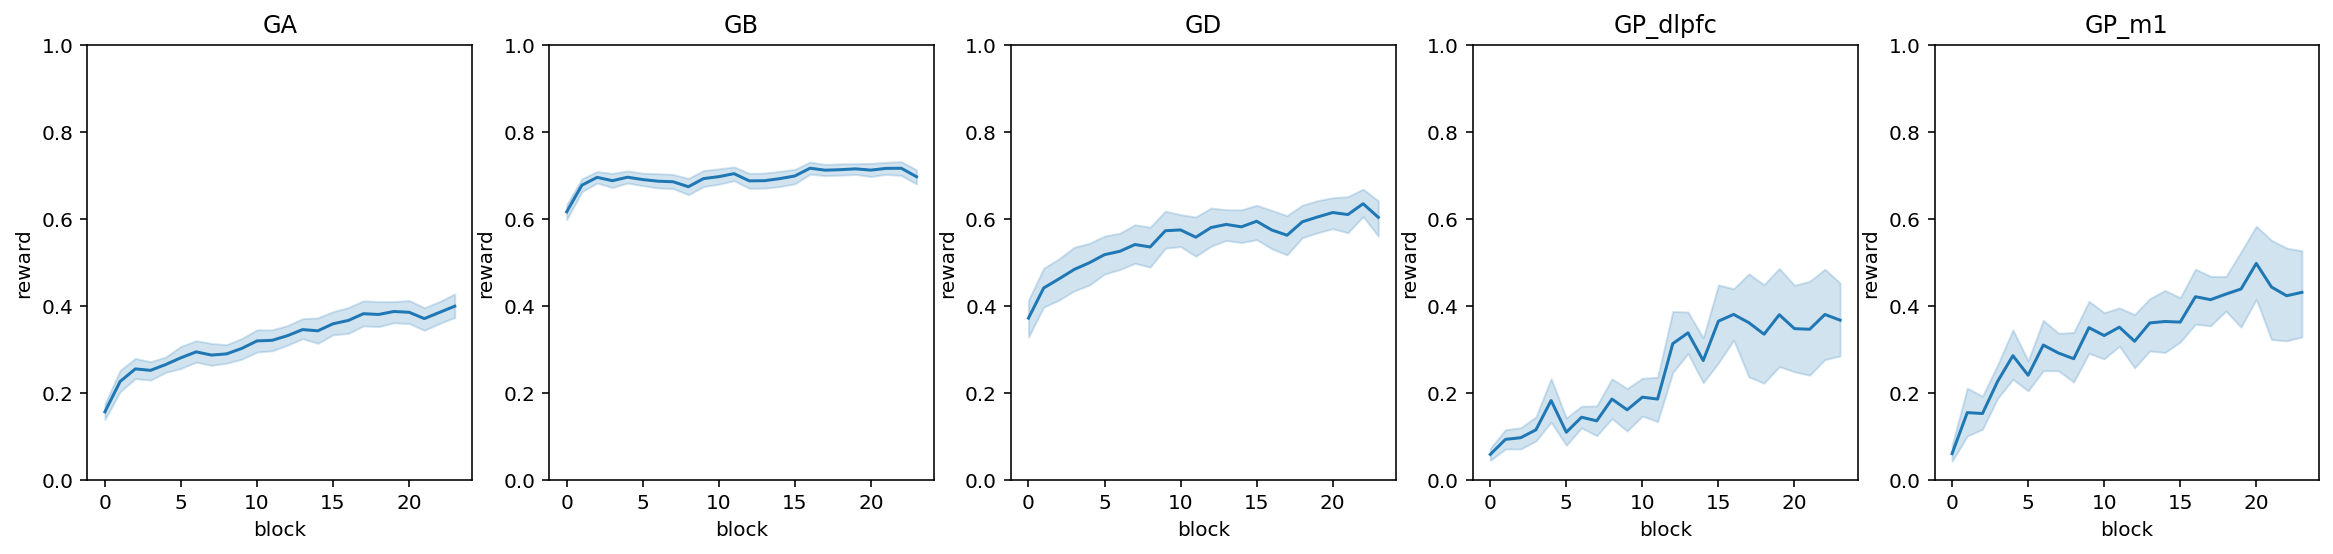

In [15]:
tmp = ['GA', 'GB', 'GD', 'GP_dlpfc', 'GP_m1']

_, axs = plt.subplots(nrows=1, ncols=len(tmp), figsize=(4*len(tmp), 4))

for i, df in enumerate([long_df_GA, long_df_GB, long_df_GD, long_df_GP_dlpfc, long_df_GP_m1]):
    ax = sns.lineplot(x='block', y='reward', data=df, ci=sig1*100, ax=axs[i])
    ax.set(ylim=(0.,1.), title=tmp[i])

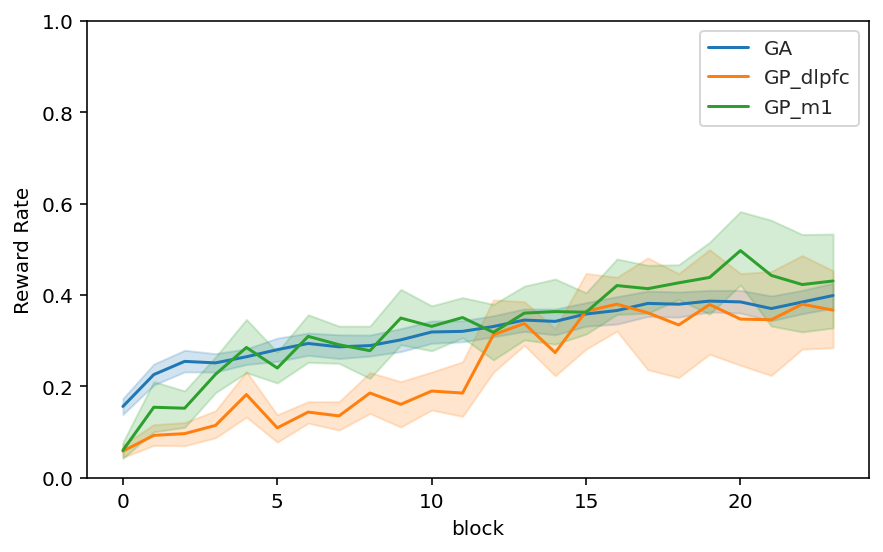

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 4.2)

tmp = ['GA', 'GP_dlpfc', 'GP_m1']
sns.set_style("whitegrid")

for i, df in enumerate([long_df_GA, long_df_GP_dlpfc, long_df_GP_m1]):
    sns.lineplot(x='block', y='reward', data=df, ci=sig1*100)
ax.set(ylim=(0.,1.), ylabel='Reward Rate')
ax.legend(tmp)

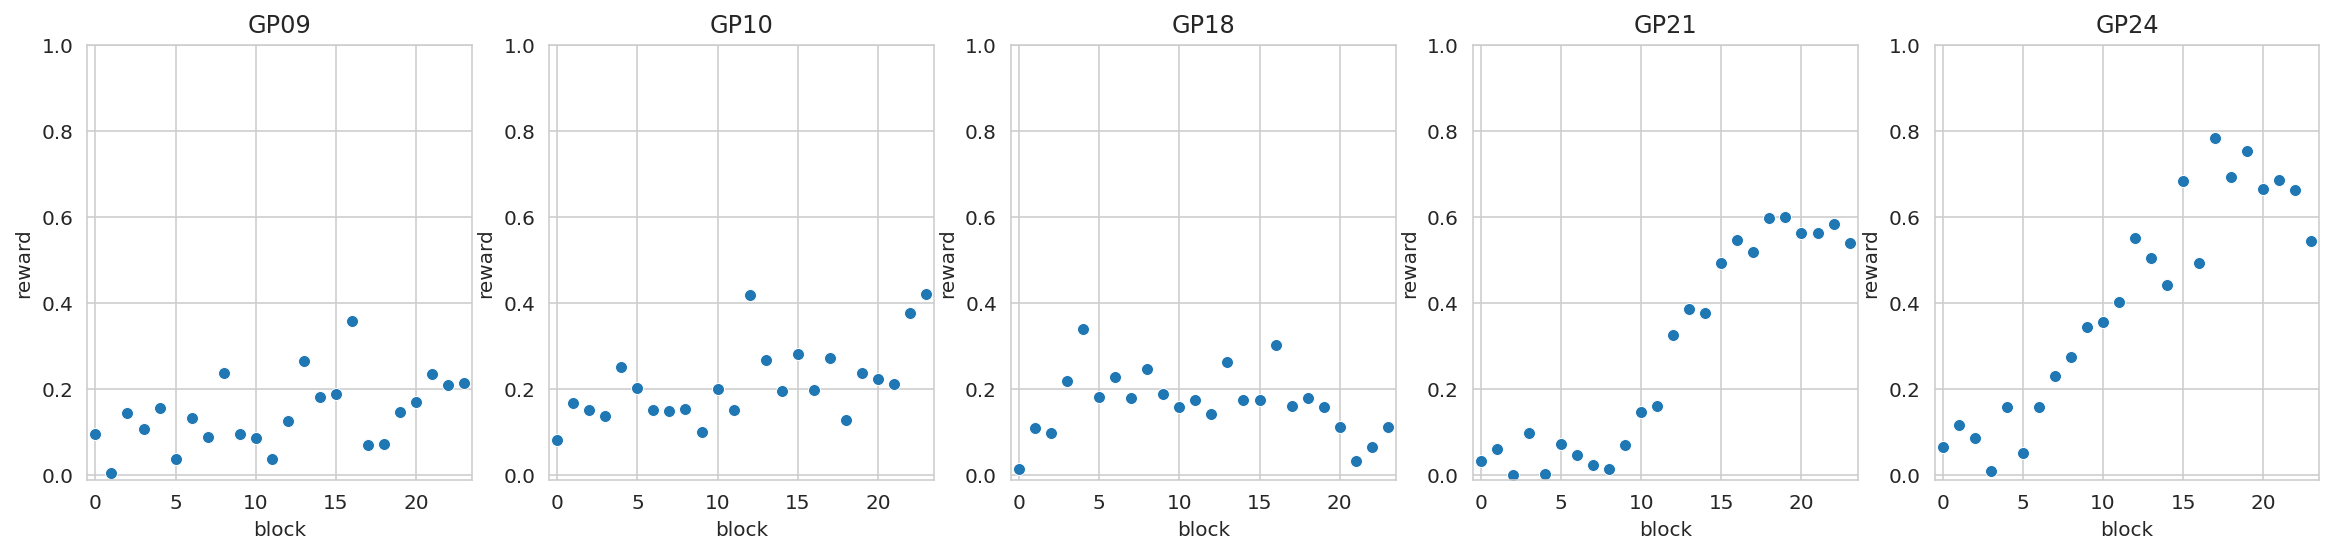

In [17]:
df = long_df_GP_dlpfc

ncol = len(df.subj.unique())
fig, axs = plt.subplots(nrows=1, ncols=ncol, figsize=(ncol*4, 4))
# axs = np.concatenate(axs)

for i, subj in enumerate(df.subj.unique()):
    ax = axs[i]
    ax = sns.scatterplot(data=df[df.subj==subj], x='block', y='reward', ax=ax)
    ax.set(xlim=(-.5,23.5), ylim=(-.01,1), title=subj)

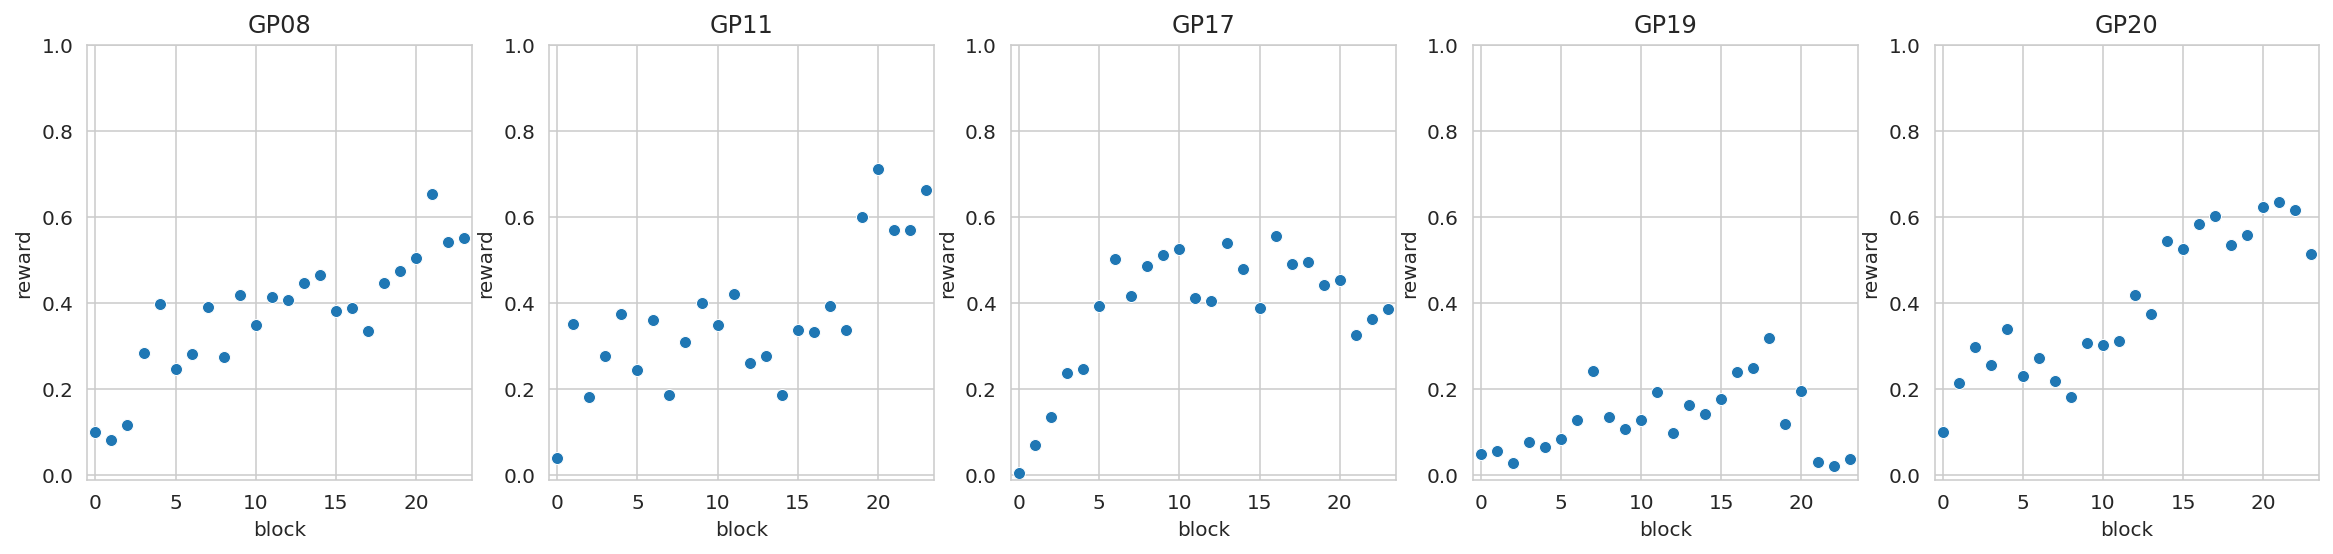

In [18]:
df = long_df_GP_m1

ncol = len(df.subj.unique())
fig, axs = plt.subplots(nrows=1, ncols=ncol, figsize=(ncol*4, 4))
# axs = np.concatenate(axs)

for i, subj in enumerate(df.subj.unique()):
    ax = axs[i]
    ax = sns.scatterplot(data=df[df.subj==subj], x='block', y='reward', ax=ax)
    ax.set(xlim=(-.5,23.5), ylim=(-.01,1), title=subj)

## curve fitting & bootstraping

In [19]:
def func_exp(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

0.2369809142237328 0.0784909072142479 0.19352902379409204


/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.



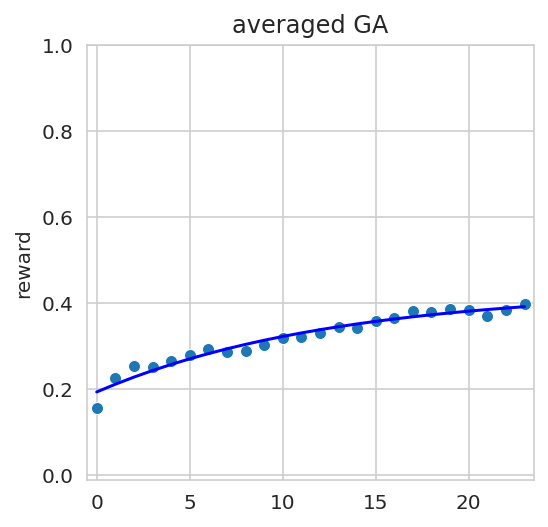

In [20]:
df = long_df_GA
title = 'averaged GA'

x = range(24)
y = df.groupby('block').mean().reward
popt_GA, _ = optimize.curve_fit(
    func_exp, x, y, maxfev=300
    , p0=[rand(),rand(),rand()]
    , bounds=([0,0,0], [2,1,1])
)

fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.scatterplot(x=range(24), y=y, ax=ax)
ax.set(xlim=(-.5,23.5), ylim=(-.01,1), title=title)
y = func_exp(x, *popt_GA)
sns.lineplot(x=x, y=y, color='b')

print(*popt_GA)

0.08058304913829772 0.9999999999999999 0.6187297960482973


/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.



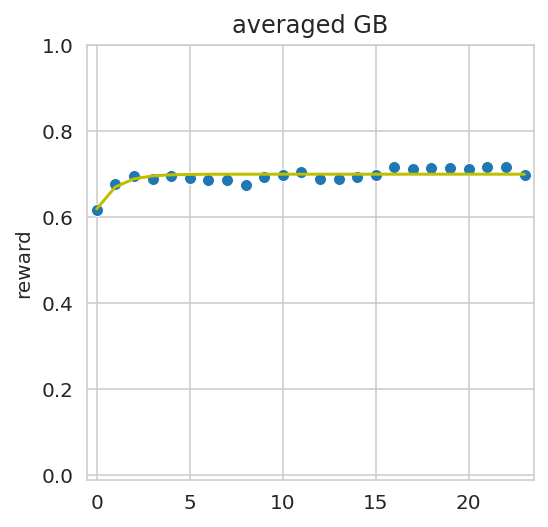

In [21]:
df = long_df_GB
title = 'averaged GB'

x = range(24)
y = df.groupby('block').mean().reward
popt_GB, _ = optimize.curve_fit(
    func_exp, x, y, maxfev=300
    , p0=[rand(),rand(),rand()]
    , bounds=([0,0,0], [2,1,1])
)

fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.scatterplot(x=range(24), y=y, ax=ax)
ax.set(xlim=(-.5,23.5), ylim=(-.01,1), title=title)
y = func_exp(x, *popt_GB)
sns.lineplot(x=x, y=y, color='y')

print(*popt_GB)

GP_dlpfc


  0%|          | 0/4000 [00:00<?, ?it/s]/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.

100%|██████████| 4000/4000 [00:53<00:00, 74.79it/s]


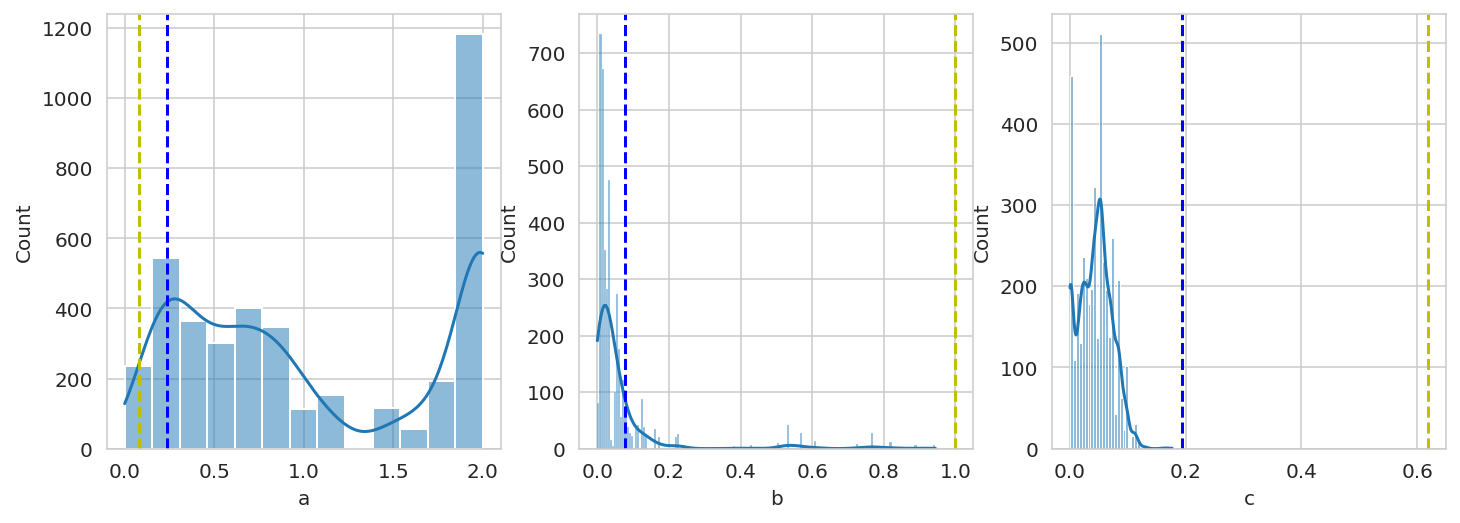

In [22]:
df = long_df_GP_dlpfc
hue = 'GP_dlpfc'
print(hue)

dpopt = pd.DataFrame(columns=['a','b','c','hue'])
x = range(24)
for i in tqdm(range(int(4e3))):
    sample = random.choices(df.subj.unique(), k=len(df.subj.unique()))
    tmp = pd.DataFrame(columns=df.columns)
    for subj in sample:
        tmp = tmp.append(df[df.subj==subj])
    y = tmp.groupby('block').mean().reward
    popt, _ = optimize.curve_fit(
        func_exp, x, y, maxfev=300
        , p0=[rand(),rand(),rand()]
        , bounds=([0,0,0], [2,1,1])
    )
    dpopt.loc[i] = [*popt, hue]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3*4,4))

for i, param in enumerate(['a','b','c']):
    ax = axs[i]
    sns.histplot(data=dpopt, x=param, stat='count', kde=True, ax=ax)
    ax.axvline(popt_GA[i], ls='--', color='b')
    ax.axvline(popt_GB[i], ls='--', color='y')

GP_m1


  0%|          | 0/4000 [00:00<?, ?it/s]/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.

100%|██████████| 4000/4000 [00:44<00:00, 89.31it/s] 


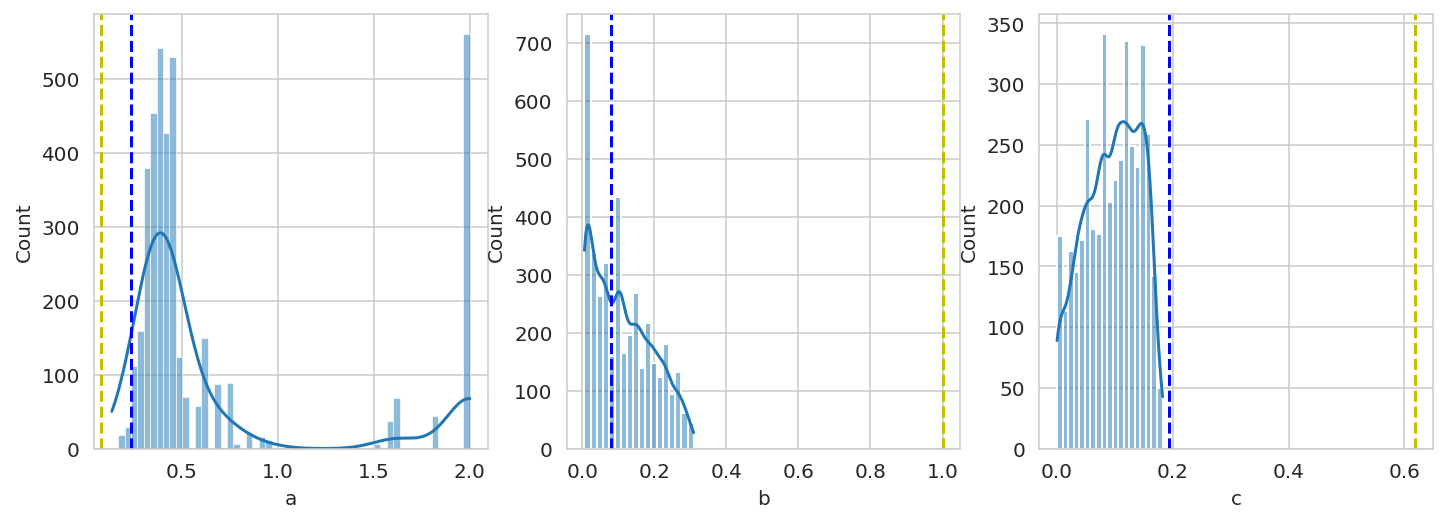

In [23]:
df = long_df_GP_m1
hue = 'GP_m1'
print(hue)

dpopt = pd.DataFrame(columns=['a','b','c','hue'])
x = range(24)
for i in tqdm(range(int(4e3))):
    sample = random.choices(df.subj.unique(), k=len(df.subj.unique()))
    tmp = pd.DataFrame(columns=df.columns)
    for subj in sample:
        tmp = tmp.append(df[df.subj==subj])
    y = tmp.groupby('block').mean().reward
    popt, _ = optimize.curve_fit(
        func_exp, x, y, maxfev=300
        , p0=[rand(),rand(),rand()]
        , bounds=([0,0,0], [2,1,1])
    )
    dpopt.loc[i] = [*popt, hue]
    
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3*4,4))

for i, param in enumerate(['a','b','c']):
    ax = axs[i]
    sns.histplot(data=dpopt, x=param, stat='count', kde=True, ax=ax)
    ax.axvline(popt_GA[i], ls='--', color='b')
    ax.axvline(popt_GB[i], ls='--', color='y')

GD


  0%|          | 0/4000 [00:00<?, ?it/s]/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.

100%|██████████| 4000/4000 [00:52<00:00, 75.96it/s]


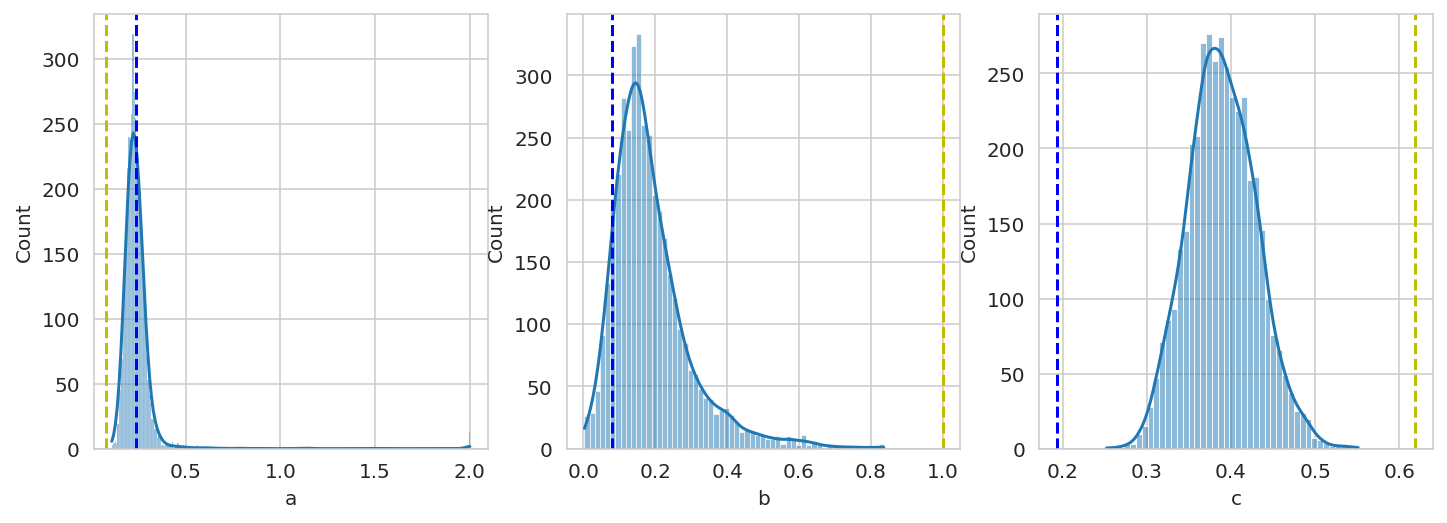

In [24]:
df = long_df_GD
hue = 'GD'
print(hue)

dpopt = pd.DataFrame(columns=['a','b','c','hue'])
x = range(24)
for i in tqdm(range(int(4e3))):
    sample = random.choices(df.subj.unique(), k=len(df.subj.unique()))
    tmp = pd.DataFrame(columns=df.columns)
    for subj in sample:
        tmp = tmp.append(df[df.subj==subj])
    y = tmp.groupby('block').mean().reward
    popt, _ = optimize.curve_fit(
        func_exp, x, y, maxfev=300
        , p0=[rand(),rand(),rand()]
        , bounds=([0,0,0], [2,1,1])
    )
    dpopt.loc[i] = [*popt, hue]
    
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3*4,4))

for i, param in enumerate(['a','b','c']):
    ax = axs[i]
    sns.histplot(data=dpopt, x=param, stat='count', kde=True, ax=ax)
    ax.axvline(popt_GA[i], ls='--', color='b')
    ax.axvline(popt_GB[i], ls='--', color='y')

## boxplot

In [25]:
df = pd.DataFrame()
row = 0
## GA
for rew in long_df_GA.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GA'
    df.loc[row, 'reward'] = rew
    row += 1
## GB
for rew in long_df_GB.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GB'
    df.loc[row, 'reward'] = rew
    row += 1
## GD
for rew in long_df_GD.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GD'
    df.loc[row, 'reward'] = rew
    row += 1
## GP_DLPFC
for rew in long_df_GP_dlpfc.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GP_DLPFC'
    df.loc[row, 'reward'] = rew
    row += 1
## GP_M1
for rew in long_df_GP_m1.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GP_M1'
    df.loc[row, 'reward'] = rew
    row += 1

df

,stage,reward
0,GA,0.366991
1,GA,0.446898
2,GA,0.397407
3,GA,0.279699
4,GA,0.442072
...,...,...
80,GP_M1,0.373090
81,GP_M1,0.364016
82,GP_M1,0.386088
83,GP_M1,0.128704


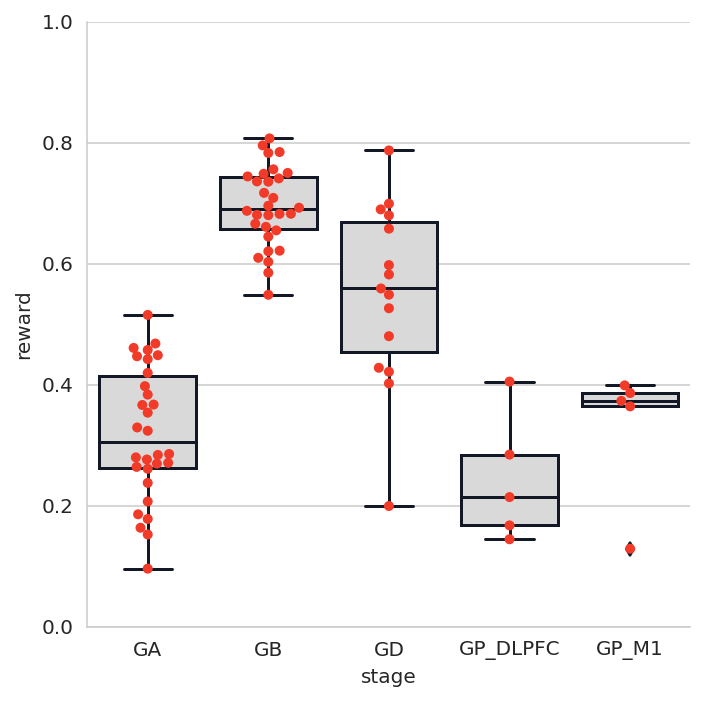

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(x='stage', y='reward', data=df, palette=["#D9D9D9"])
sns.swarmplot(x='stage', y='reward', data=df, size=5, color="#F23A29", linewidth=0)

plt.ylim(0, 1.0)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

for i, artist in enumerate(ax.artists):
    artist.set_edgecolor("#131826")
    
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color("#131826")
        line.set_mfc("#131826")
        line.set_mec("#131826")
        
#for e, l in zip(early_rwd, late_rwd):
#    line = plt.plot((0, 1), (e, l), '-', linewidth=1)
#    line[0].set_color("#99999999")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,         # ticks along the top edge are off
)

plt.tight_layout()

fig.set_facecolor('white')

# fig.savefig(fname=today+'_behav2.png', dpi=300)

In [27]:
df = pd.DataFrame()
row = 0
## GA
for rew in long_df_GA.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GA'
    df.loc[row, 'reward'] = rew
    row += 1
## GP_DLPFC
for rew in long_df_GP_dlpfc.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GP_DLPFC'
    df.loc[row, 'reward'] = rew
    row += 1
## GP_M1
for rew in long_df_GP_m1.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GP_M1'
    df.loc[row, 'reward'] = rew
    row += 1

df

,stage,reward
0,GA,0.366991
1,GA,0.446898
2,GA,0.397407
3,GA,0.279699
4,GA,0.442072
5,GA,0.185579
6,GA,0.263993
7,GA,0.366285
8,GA,0.163391
9,GA,0.329167


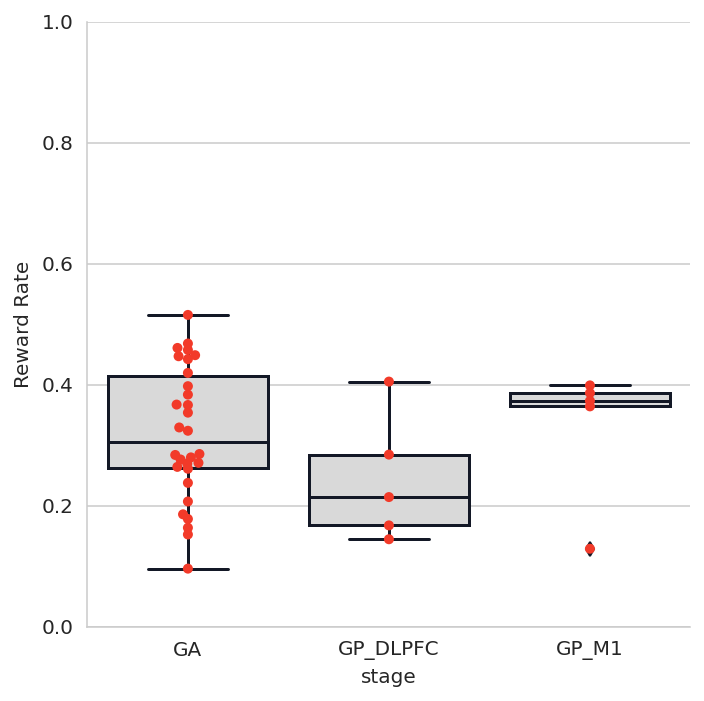

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(x='stage', y='reward', data=df, palette=["#D9D9D9"])
sns.swarmplot(x='stage', y='reward', data=df, size=5, color="#F23A29", linewidth=0)
ax.set(ylabel='Reward Rate')

plt.ylim(0, 1.0)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

for i, artist in enumerate(ax.artists):
    artist.set_edgecolor("#131826")
    
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color("#131826")
        line.set_mfc("#131826")
        line.set_mec("#131826")
        
#for e, l in zip(early_rwd, late_rwd):
#    line = plt.plot((0, 1), (e, l), '-', linewidth=1)
#    line[0].set_color("#99999999")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,         # ticks along the top edge are off
)

plt.tight_layout()

fig.set_facecolor('white')

# fig.savefig(fname=today+'_behav2.png', dpi=300)

In [29]:
a = list(long_df_GA.groupby(['subj']).mean()['reward'])
p = list(long_df_GP_dlpfc.groupby(['subj']).mean()['reward'])
print('GA vs. GP_DLPFC')
scipy.stats.ttest_ind(a, p, alternative='two-sided')

GA vs. GP_DLPFC


Ttest_indResult(statistic=1.4503524806626684, pvalue=0.1563994104961464)

In [30]:
a = list(long_df_GA.groupby(['subj']).mean()['reward'])
p = list(long_df_GP_m1.groupby(['subj']).mean()['reward'])
print('GA vs. GP_M1')
scipy.stats.ttest_ind(a, p, alternative='two-sided')

GA vs. GP_M1


Ttest_indResult(statistic=-0.1976200856733425, pvalue=0.8445545893305737)